# Predict Future Sales Competition
### Task: forecast the total amount of products sold in every shop for the test set.
Note that the list of shops and products slightly changes every month.

## Setting up

In [1]:
# basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings("ignore")

# check versions of selected libraries for reference
for lib in [pd, np, sns]:
    print(lib.__name__, lib.__version__)

pandas 1.2.3
numpy 1.19.5
seaborn 0.11.1


In [2]:
# custom function to downcast numerics to smallest possible int/float dtype
# avoids memory errors with kaggle
def downcast_dtypes(df, verbose=True):
    float_cols = [col for col in df if df[col].dtype == 'float64']
    int_cols = [col for col in df if df[col].dtype == 'int64']
    
    if verbose:
        mem = np.sum(df.memory_usage()) / (1024**2)
        print('Old dataframe memory usage:\t {:.1f} MB'.format(mem))
    
    for float_col in float_cols:
        df[float_col] = pd.to_numeric(df[float_col], downcast='float')  # float32
    
    for int_col in int_cols:
        df[int_col] = pd.to_numeric(df[int_col], downcast='integer')    # int8
    
    if verbose:
        mem = np.sum(df.memory_usage()) / (1024**2)
        print('New dataframe memory usage:\t {:.1f} MB'.format(mem))
    
    return df

## Read and view data

In [3]:
item_cats = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')

sample_submission = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')
train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')

## Basic adjustments to train set and checks
1. Join shops, item_cats and items with train set for easy viewing
2. Check for NaNs (none in this dataset)
3. Check for wholly duplicated rows and remove them
4. Convert date to datetime dtype
5. Check dtypes

In [4]:
# join items dataframe with categories dataframe
items_with_cat = items.join(item_cats.set_index('item_category_id'), on='item_category_id', how='left')

# then join result with train dataframe
train = train.join(items_with_cat.set_index('item_id'), on='item_id', how='left') \
            .join(shops.set_index('shop_id'), on='shop_id', how='left')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


In [5]:
train.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
dtype: int64

In [6]:
# print number of duplicate rows and display all duplicates
print('Number of duplicate rows: ', train.duplicated().sum())
train.loc[train.duplicated()]

Number of duplicate rows:  6


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
76962,05.01.2013,0,54,20130,149.0,1.0,УЧЕНИК ЧАРОДЕЯ (регион),40,Кино - DVD,"Химки ТЦ ""Мега"""
1435367,23.02.2014,13,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360,"Тюмень ТЦ ""Гудвин"""
1496766,23.03.2014,14,21,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360,"Москва МТРЦ ""Афи Молл"""
1671873,01.05.2014,16,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360,"Тюмень ТЦ ""Гудвин"""
1866340,12.07.2014,18,25,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360,"Москва ТРК ""Атриум"""
2198566,31.12.2014,23,42,21619,499.0,1.0,ЧЕЛОВЕК ДОЖДЯ (BD),37,Кино - Blu-Ray,"СПб ТК ""Невский Центр"""


In [7]:
# drop duplicates in place
train.drop_duplicates(inplace=True)
print('Number of duplicate rows: ', train.duplicated().sum())

Number of duplicate rows:  0


In [8]:
# convert date to datetime
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')
train['date'].head()

0   2013-01-02
1   2013-01-03
2   2013-01-05
3   2013-01-06
4   2013-01-15
Name: date, dtype: datetime64[ns]

In [9]:
# check dtypes
train.dtypes

date                  datetime64[ns]
date_block_num                 int64
shop_id                        int64
item_id                        int64
item_price                   float64
item_cnt_day                 float64
item_name                     object
item_category_id               int64
item_category_name            object
shop_name                     object
dtype: object

## Basic adjustments to test set
1. Add date_block_num == 34 to facilitate feature generation and model training
2. Join item_cats and items with test set 

In [10]:
test['date_block_num'] = 34

# join items_with_cats with test dataframe
test = test.join(items_with_cat.set_index('item_id'), on='item_id', how='left')
test.head()

,ID,shop_id,item_id,date_block_num,item_name,item_category_id,item_category_name
0,0,5,5037,34,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3
1,1,5,5320,34,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства
2,2,5,5233,34,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3
3,3,5,5232,34,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360
4,4,5,5268,34,"Need for Speed [PS4, русская версия]",20,Игры - PS4


# 1. Exploratory Data Analysis

In [11]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06
mean,1.456991e+01,3.300171e+01,1.019723e+04,8.908535e+02,1.242641e+00,4.000141e+01
std,9.422992e+00,1.622698e+01,6.324293e+03,1.729801e+03,2.618837e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


## Correlation between features

<AxesSubplot:>

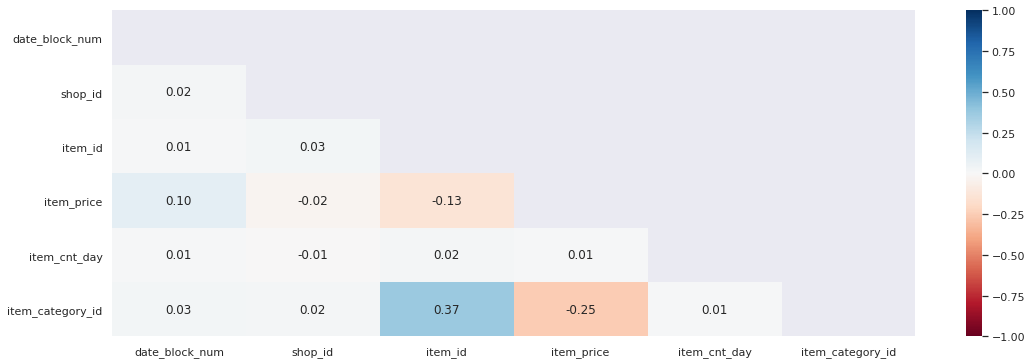

In [12]:
# plot diagonal correlation matrix
corr = train[['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_category_id']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f = plt.subplots(figsize=(18, 6))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=mask, cmap='RdBu', fmt='.2f')

Observation:
* There seems to be some weak correlation between item categories with items and item prices. Other features have almost no correlation.

## Plot distribution of each feature in train set

Note: due to the large number of distinct IDs in the dataset, histogram plots have binned several IDs together and shown their combined frequency.

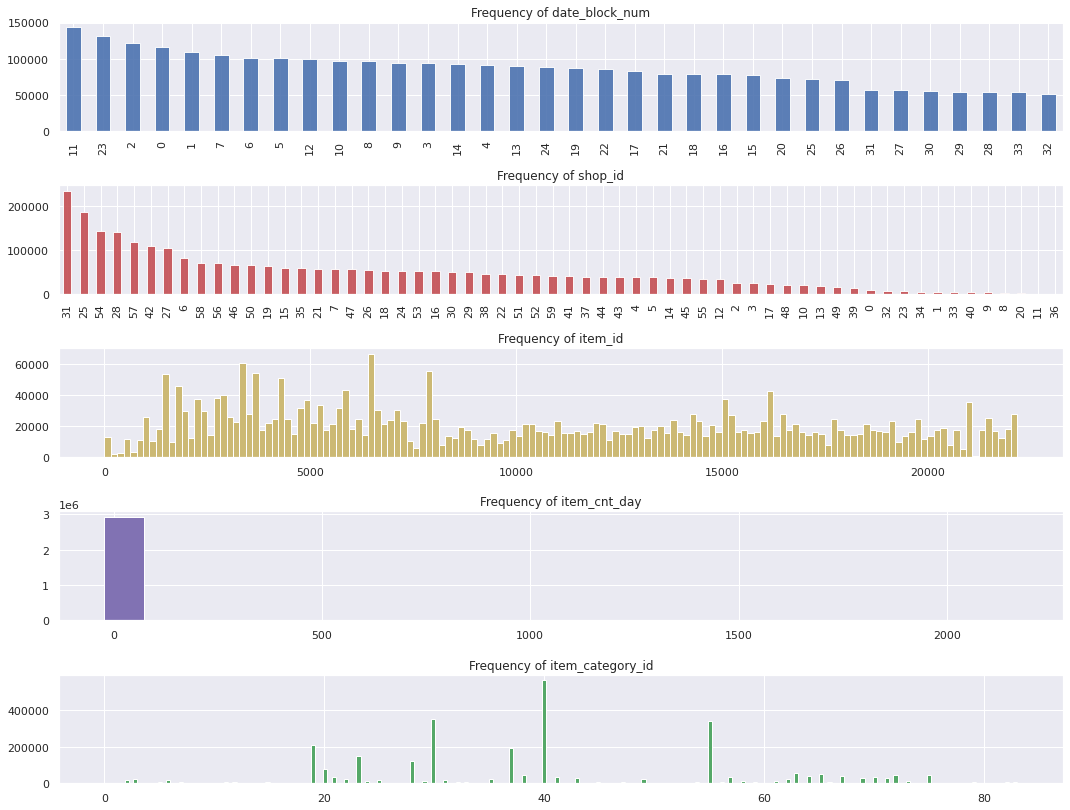

In [13]:
f = plt.figure(figsize=(18,14))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((5,1), (0,0), colspan = 1)
train['date_block_num'].value_counts().plot(kind='bar', alpha=0.9, color='b')
plt.title('Frequency of date_block_num')

plt.subplot2grid((5,1), (1,0), colspan = 1)
train['shop_id'].value_counts().plot(kind='bar', alpha=0.9, color='r')
plt.title('Frequency of shop_id')

plt.subplot2grid((5,1), (2,0), colspan = 1)
plt.hist(train['item_id'], bins='auto', color='y')
plt.title('Frequency of item_id')

plt.subplot2grid((5,1), (3,0), colspan = 1)
plt.hist(train['item_cnt_day'], bins='auto', color='m')
plt.title('Frequency of item_cnt_day')

plt.subplot2grid((5,1), (4,0), colspan = 1)
plt.hist(train['item_category_id'], bins='auto', color='g')
plt.title('Frequency of item_category_id')

plt.show()

Observations for the train set:
1. There are generally fewer rows of data for larger values of date_block_num.
2. We can observe a huge imbalance in shop_id, item_id and item_category_id.

## Plot distribution of each feature in test set

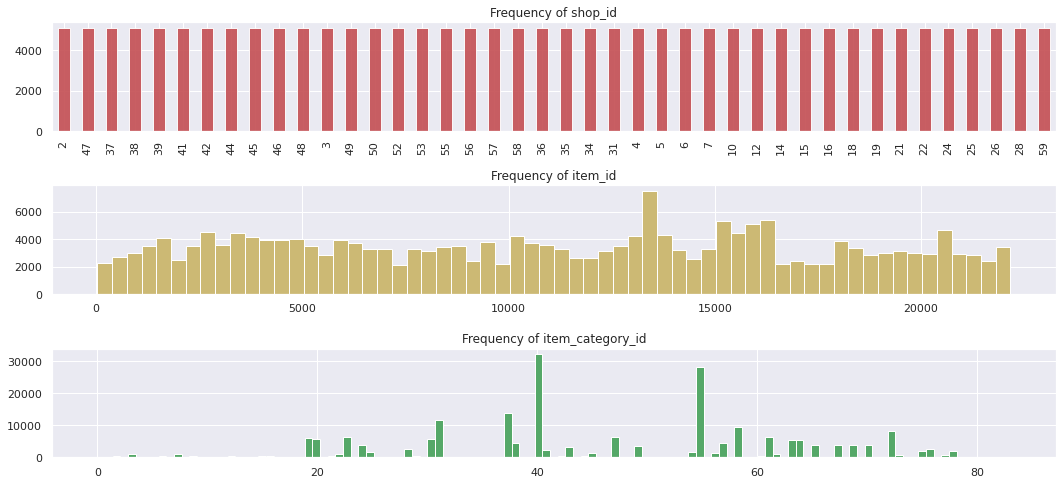

In [14]:
f = plt.figure(figsize=(18,14))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((5,1), (1,0), colspan = 1)
test['shop_id'].value_counts().plot(kind='bar', alpha=0.9, color='r')
plt.title('Frequency of shop_id')

plt.subplot2grid((5,1), (2,0), colspan = 1)
plt.hist(test['item_id'], bins='auto', color='y')
plt.title('Frequency of item_id')

plt.subplot2grid((5,1), (3,0), colspan = 1)
plt.hist(test['item_category_id'], bins='auto', color='g')
plt.title('Frequency of item_category_id')

plt.show()

### Similarity of train/test distributions
Observations for the test set:
1. shop_id is evenly distributed.
2. Not all shop_ids and item_ids are represented in the test set. This can be inferred from the width of the bars and markings on x axis.

We should identify if there are any shop_id, item_id or item_category_id values that appear in the test set, that do not appear in the train set.

In [15]:
print('Number of unique shop_id values in train:', train['shop_id'].nunique())
print('Number of unique shop_id values in test:', test['shop_id'].nunique())
# are all elements of test.shop_id in train.shop_id?
print(np.isin(test['shop_id'].unique(), train['shop_id'].unique()).all())

print('Number of unique item_id values in train:', train['item_id'].nunique())
print('Number of unique item_id values in test:', test['item_id'].nunique())
# are all elements of test.item_id in train.item_id?
print(np.isin(test['item_id'].unique(), train['item_id'].unique()).all())

print('Number of unique item_category_id values in train:', train['item_category_id'].nunique())
print('Number of unique item_category_id values in test:', test['item_category_id'].nunique())
# are all elements of test.item_category_id in train.item_category_id?
print(np.isin(test['item_category_id'].unique(), train['item_category_id'].unique()).all())

Number of unique shop_id values in train: 60
Number of unique shop_id values in test: 42
True
Number of unique item_id values in train: 21807
Number of unique item_id values in test: 5100
False
Number of unique item_category_id values in train: 84
Number of unique item_category_id values in test: 62
True


In [16]:
print('Number of items in test that are not in train: ',
      np.isin(test['item_id'].unique(), train['item_id'].unique(), invert=True).sum())

Number of items in test that are not in train:  363


* From this we can tell that all shops that appear in test also appear in train.
* However, not all individual items in test appear in train. We cannot prune item_id from train set to match item_id of test set exactly. That being said, all item categories in test DO appear in train. **Therefore, item categories (and generated features) MIGHT be more useful to generalise predictions to test set.**
* When training our eventual model, we also need to explicitly include, in the train set for each month, **all shop-item combinations that have ever appeared for that month.** This feature matrix would allow eventual model to consider items in each month that did not get sold in particular shops.

## Examining transactions (item_cnt_day aggregated to month)

In [17]:
train['shop_id'] = train['shop_id'].astype(np.int64)

### Taking mean and total of item count per month of all shops

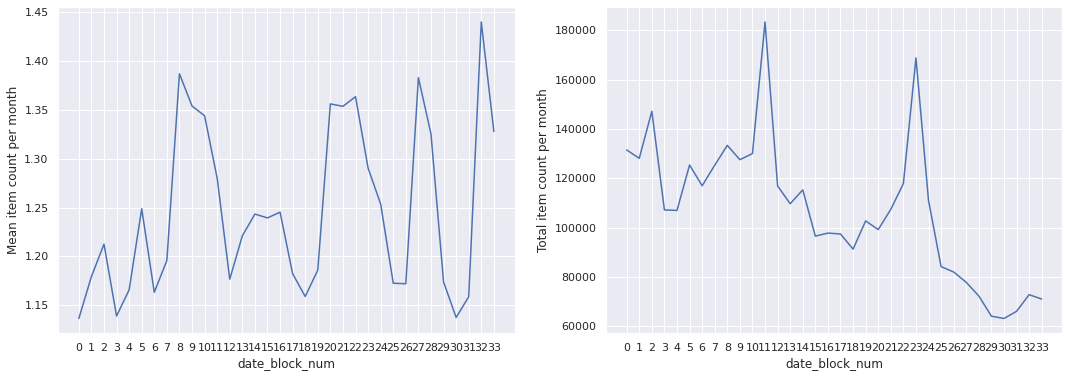

In [18]:
f, axs = plt.subplots(1, 2, figsize=(18,6))
sns.lineplot(data=train.groupby('date_block_num')['item_cnt_day'].agg('mean'), ax=axs[0])
axs[0].set_ylabel('Mean item count per month')
axs[0].set_xticks(np.arange(0, 34, 1))
sns.lineplot(data=train.groupby('date_block_num')['item_cnt_day'].agg('sum'), ax=axs[1])
axs[1].set_ylabel('Total item count per month')
axs[1].set_xticks(np.arange(0, 34, 1))
plt.show()

Observations:
* A high mean item count does not always correspond to a high total item count.
* Transactions seem to follow a general downward trend as the months progressed.
* The data appears seasonal. There are two significant spikes in transactions - namely month 11 and month 23 - which are exactly 12 months apart. This corresponds to a holiday season and we can confirm that both these months are the months of December. Whereas, dips in transactions are seen around months 16-18 and 29-31, corresponding to the middle of the year.

In [19]:
train.loc[train['date_block_num'] == 11, 'date'].head()

1124316   2013-12-04
1124317   2013-12-15
1124318   2013-12-22
1124319   2013-12-31
1124320   2013-12-18
Name: date, dtype: datetime64[ns]

### Taking mean and total of item count per month for each shop

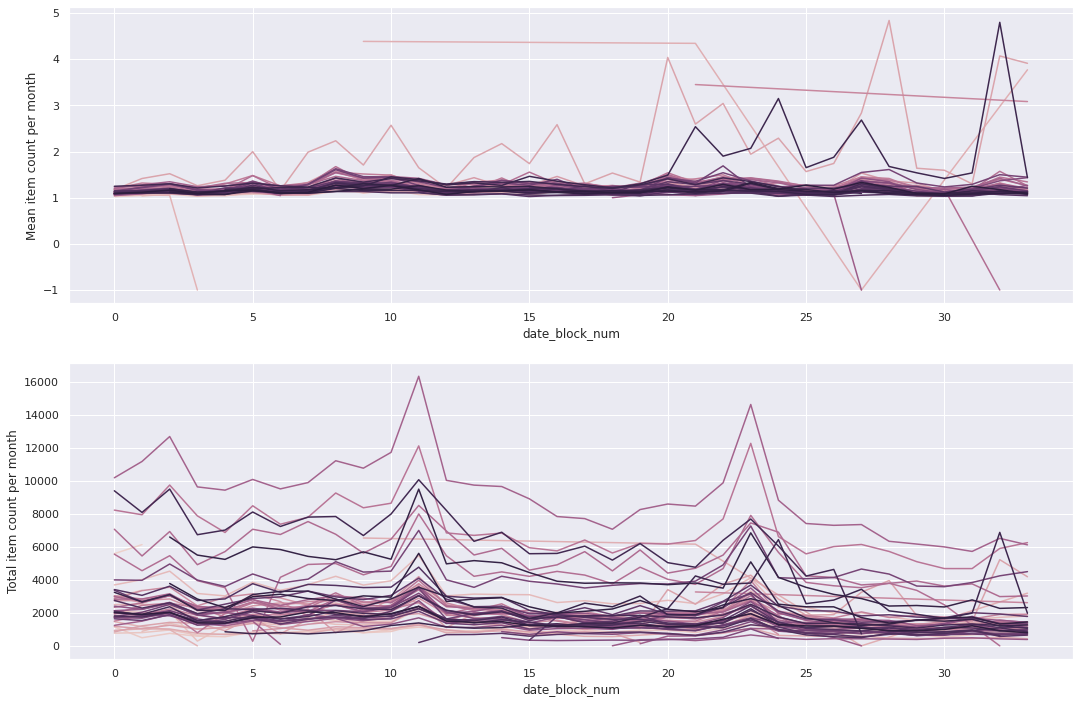

In [20]:
f, axs = plt.subplots(2, 1, figsize=(18,12))

# mean and sum of item count by MONTH
agg_mean = train.groupby(['shop_id', 'date_block_num']).agg({'item_cnt_day': 'mean'})
agg_sum = train.groupby(['shop_id', 'date_block_num']).agg({'item_cnt_day': 'sum'})

# plot mean of item count by MONTH vs time (months)
sns.lineplot(data=agg_mean, x='date_block_num', y='item_cnt_day', hue='shop_id', legend=False, ax=axs[0])
axs[0].set_ylabel('Mean item count per month')

# plot sum of item count by MONTH vs time (months)
sns.lineplot(data=agg_sum, x='date_block_num', y='item_cnt_day', hue='shop_id', legend=False, ax=axs[1])
axs[1].set_ylabel('Total item count per month')

plt.show()

Observations:
* Some shops experience high fluctuations in items sold. **Smoothing/regularization techniques may be applied to the item count (eg. windowing).**
* Several lines do not extend completely from date_block_num == 0 to date_block_num == 33 in the graph of mean item count. This shows that some shops have no recorded items sold in certain months.

In fact, we can confirm that no month in the dataset contains transactions from every shop.

In [21]:
months_with_all_shops = []

# find whether all shops are represented for each month
for month in train['date_block_num'].unique():
    s = train.loc[train['date_block_num'] == month, 'shop_id'].nunique() == train['shop_id'].nunique()
    months_with_all_shops.append(s)

sum(months_with_all_shops) # count of months where all shops are represented

0

### Checking distribution/outliers

<AxesSubplot:xlabel='item_cnt_day'>

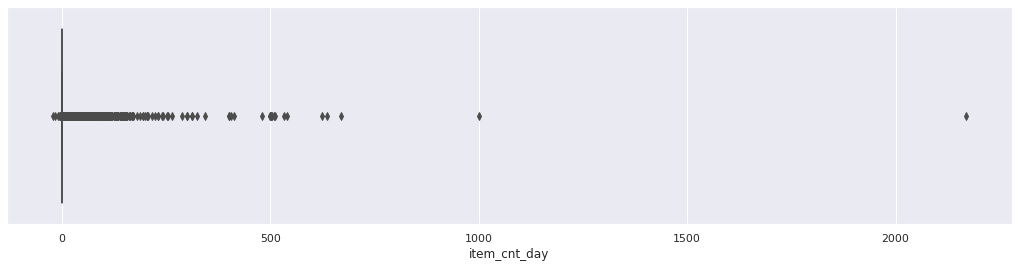

In [22]:
f = plt.subplots(figsize=(18,4))
sns.boxplot(train['item_cnt_day'])

There are several items sold hundreds or even thousands of times in a single day. On the negative side, there are several items with many more returns than purchases in a single day. These situations could be realistic/unrealistic depending on the item being sold, hence we can inspect the details of these outliers.

In [23]:
train.loc[train['item_cnt_day'] > 500, :].sort_values('item_cnt_day', ascending=False)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
2909818,2015-10-28,33,12,11373,0.908714,2169.0,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
2326930,2015-01-15,24,12,20949,4.000000,1000.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",Интернет-магазин ЧС
2864235,2015-09-30,32,12,9248,1692.526158,669.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",80,Служебные - Билеты,Интернет-магазин ЧС
2851091,2015-09-30,32,55,9249,1702.825746,637.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8,Билеты (Цифра),Цифровой склад 1С-Онлайн
2608040,2015-04-14,27,12,3731,1904.548077,624.0,"Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания,Интернет-магазин ЧС
2626181,2015-05-19,28,12,11373,155.192950,539.0,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
2851073,2015-09-29,32,55,9249,1500.000000,533.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8,Билеты (Цифра),Цифровой склад 1С-Онлайн
2048518,2014-10-02,21,12,9242,1500.000000,512.0,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",8,Билеты (Цифра),Интернет-магазин ЧС
2067669,2014-10-09,21,55,19437,899.000000,508.0,"Средиземье: Тени Мордора [PC, Цифровая версия]",31,Игры PC - Цифра,Цифровой склад 1С-Онлайн
2864260,2015-09-29,32,12,9248,1500.000000,504.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",80,Служебные - Билеты,Интернет-магазин ЧС


Most items with high item_cnt_day turn out to be show tickets or popular video game titles, and hundreds of these items sold in a day is definitely plausible. It is further noted that none of these large outliers come from months 11 or 23, further confirming that those December months have natural increases in transactions.<br>

The two biggest positive outliers are (using google translate, not exact translations):
* Branded package white T-shirt (item_id == 20949, item_cnt_day == 1000)
* Delivery by Boxberry (a courier service) (item_id == 11373, item_cnt_day == 2169)

We can also plot the item_cnt_day distribution of both of these items separately.

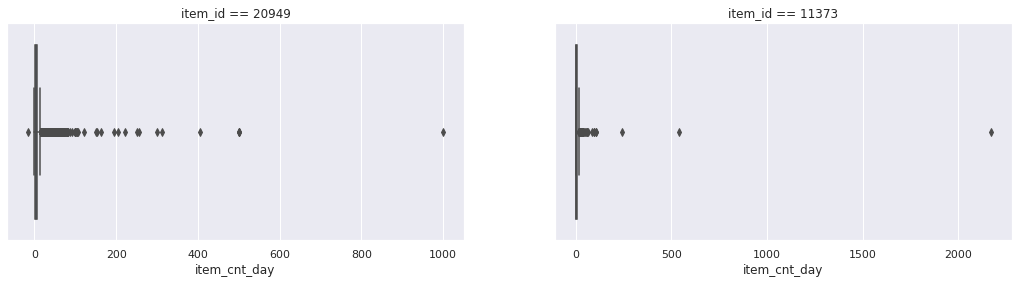

In [24]:
f, ax = plt.subplots(1, 2, figsize=(18,4))
sns.boxplot(train.loc[train['item_id'] == 20949, :]['item_cnt_day'], ax=ax[0])
ax[0].set_title('item_id == 20949')
sns.boxplot(train.loc[train['item_id'] == 11373, :]['item_cnt_day'], ax=ax[1])
ax[1].set_title('item_id == 11373')
plt.show()

### Negative item_cnt_day

There are several rows with negative item_cnt_day, meaning that the number of returns of an item in a shop was higher than that of purchases of that item in a single day. Compared to the dataset, there are relatively very few rows with negative item_cnt_day (7356 vs 2928487). **We can consider removing rows with negative item_cnt_day if it leads to better predictions, as it does not affect the dataset too significantly.**<br>

It is also good to note that there are no rows where item_cnt_day == 0.

In [25]:
print('Rows with negative item_cnt_day: ', train.loc[train['item_cnt_day'] < 0, :].shape[0])
print('Rows with positive item_cnt_day: ', train.loc[train['item_cnt_day'] > 0, :].shape[0])
print('Rows with zero item_cnt_day:     ', train.loc[train['item_cnt_day'] == 0, :].shape[0])

Rows with negative item_cnt_day:  7356
Rows with positive item_cnt_day:  2928487
Rows with zero item_cnt_day:      0


## Examining shop_id and shop_name

**A quick visual inspection of shop names reveals that some shop names look very similar.** We should check if duplicate shops are present in the dataset as their existence will unbalance the equal distribution of shops in the test set, which will most likely affect model performance. Normally, this would not be possible if names for the respective shops were not provided. Since the given data allows this luxury, we can investigate this and maintain good distribution of shops.

I believe there are several ways to do this, such as word embeddings (eg. word2vec). For convenience, a publicly available Python [library](https://github.com/luozhouyang/python-string-similarity) that implements similarity and distance measures will be used to calculate normalised Levenshtein distance between each pair of shop names in the dataset.

(Levenshtein distance between two words is the minimum number of insertions, deletions or substitutions required to change one word into the other.)

In [26]:
!pip install -U strsimpy

     |████████████████████████████████| 45 kB 987 kB/s eta 0:00:01


In [27]:
from strsimpy.normalized_levenshtein import NormalizedLevenshtein
normalized_levenshtein = NormalizedLevenshtein()

# function to calculate levenshtein distances for all input pairs
def calc_levenshtein(col):
    col_similarity = []
    for name1 in col:
        x = []
        for name2 in col:
            x.append(normalized_levenshtein.distance(name1, name2))
        col_similarity.append(x)
    return pd.DataFrame(col_similarity)

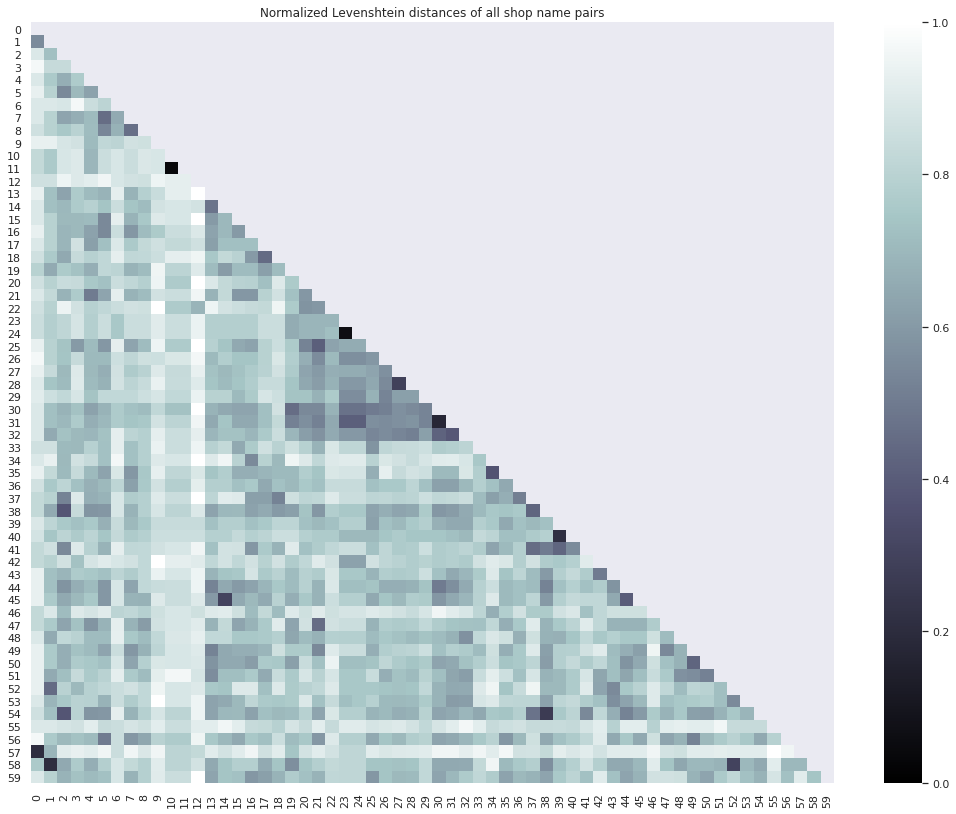

In [28]:
shop_similarity = calc_levenshtein(shops['shop_name'])
mask = np.triu(np.ones_like(shop_similarity, dtype=bool))

f = plt.subplots(figsize=(18, 14))
sns.heatmap(shop_similarity, vmin=0, vmax=1, mask=mask, cmap='bone', fmt='.2f')
plt.title('Normalized Levenshtein distances of all shop name pairs')
plt.show()

A normalized Levenshtein distance value of 0 indicates that two words are the same. From the heatmap, we can quickly identify several pairs of shops that have very similar names:
* 0 and 57
* 1 and 58
* 11 and 10
* 23 and 24
* 30 and 31
* 40 and 39

We should now examine the names of these shops.

In [29]:
shops.loc[shops['shop_id'].isin([0, 1, 10, 11, 23, 24, 30, 31, 39, 40, 57, 58])]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11
23,"Москва ТК ""Буденовский"" (пав.А2)",23
24,"Москва ТК ""Буденовский"" (пав.К7)",24
30,"Москва ТЦ ""Перловский""",30
31,"Москва ТЦ ""Семеновский""",31
39,"РостовНаДону ТРК ""Мегацентр Горизонт""",39
40,"РостовНаДону ТРК ""Мегацентр Горизонт"" Островной",40


Observations:

From the above as well as observing shop_name overall, we can infer that shop_id was encoded in Russian alphabetical order of shop names without first accounting for string formatting issues. As a result, some of these pairs turn out to be the same and **their shop_ids should be corrected in both train and test sets:**
* 0 and 57
* 1 and 58
* 10 and 11
* 39 and 40

Translating shop names reveal that they contain the location of the shop. **We can generate a feature for location (city).**

## Examining item_id and item_name
Similar items turn out to have names of similar length. **Length of item name could be a feature** as it may contain information about how similar items are to one another.

In [30]:
# get names of items in same category and show that names are similar
items_with_cat.loc[items_with_cat['item_category_id'] == 100, 'item_name']

Series([], Name: item_name, dtype: object)

## Examining item_category_id

Item categories already have a skewed distribution in the test set. Finding a way to make sense of the item categories would help us to build features that can better account for item categories.

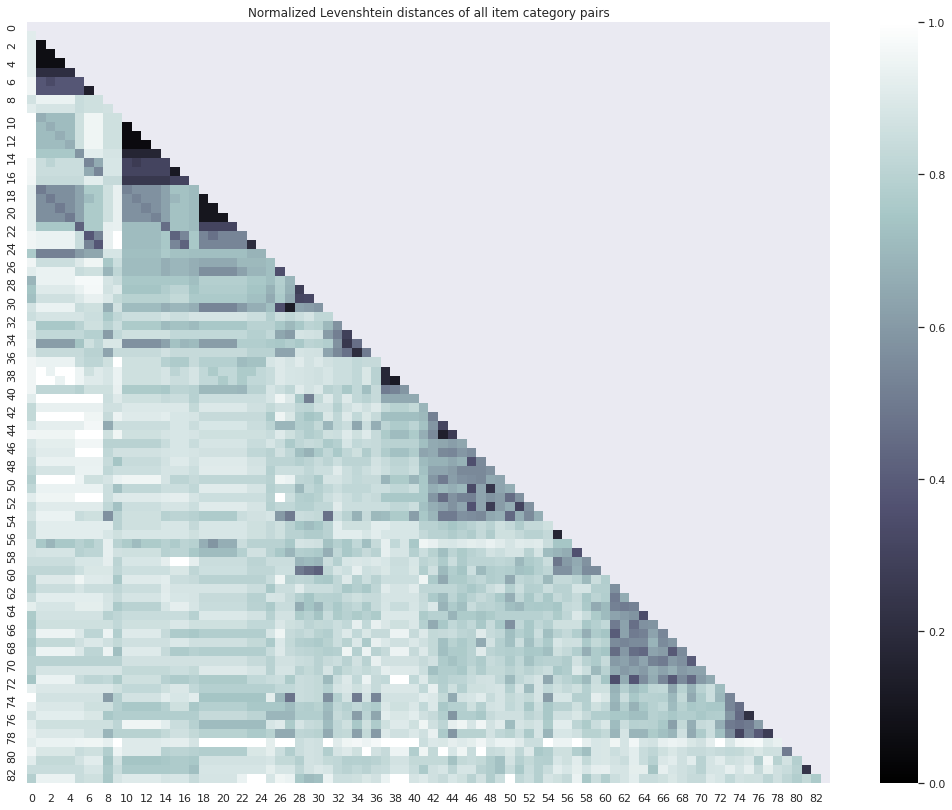

In [31]:
item_cats_similarity = calc_levenshtein(item_cats['item_category_name'])
mask = np.triu(np.ones_like(item_cats_similarity, dtype=bool))

f = plt.subplots(figsize=(18, 14))
sns.heatmap(item_cats_similarity, vmin=0, vmax=1, mask=mask, cmap='bone', fmt='.2f')
plt.title('Normalized Levenshtein distances of all item category pairs')
plt.show()

By plotting the heatmap, we can quickly observe that there are clusters of very similar item category names. By inspecting the actual item category names, it is apparent that **subcategories are present in the list of item categories.** These subcategories belong to bigger groups, such as "accessories" (Аксессуары) or "game consoles" (Игровые консоли).

Knowing this, **we can generate two new features, namely the "main category" and subcategory of each item.**

In [32]:
item_cats.head(15)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [33]:
del shop_similarity
del item_cats_similarity

## Examining item_price
Earlier, we found that not all items in test appear in train. Furthermore, the price of many items change over the months. Since item_price feature is only present in train, we do not have the price of items that only appear in test. Therefore, the best thing we can do is to **possibly generate features based on aggregating item price by item category for each month.**

In [34]:
# check if any item prices have changed throughout the months for any item
item_price_change = []
for item in train['item_id'].unique():
    x = train.loc[train['item_id'] == item, 'item_price'].nunique()
    item_price_change.append(x)

In [35]:
print('Number of items with fluctuating price: \t', train['item_id'].nunique() - item_price_change.count(1))

Number of items with fluctuating price: 	 15881


We need to check for negative item prices as that is unrealistic - turns out there is an entry with item_price of -1. **Negative item prices must be removed.**

In [36]:
train.loc[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
484683,2013-05-15,4,32,2973,-1.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,"Москва ТЦ ""Серебряный Дом"""


Plotting the distribution of item_price reveals several outliers that may also be removed if it improves the model score.

<AxesSubplot:xlabel='item_price'>

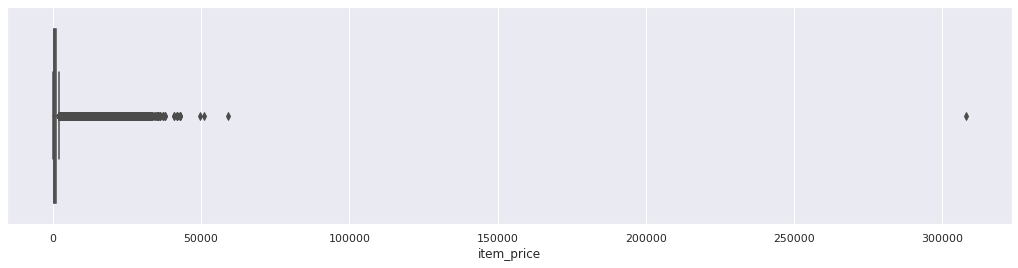

In [37]:
f = plt.subplots(figsize=(18,4))
sns.boxplot(train['item_price'])

# 2. Data preprocessing and feature generation
Summary of preprocessing steps:
* Dropping names from train set which we merged earlier, since features can be generated from them separately
* Correcting duplicate shops
* Removing of shops in train set that do not appear in test
* Removing item_price and item_cnt_day outliers
* Explicitly including, for each month, every shop-item combination that has ever appeared in that particular month. In other words, a feature matrix (cartesian product) is created
* **Generating target feature** (total amount of each item sold in each shop in a month) by aggregating data by month, shop and item
* Merging train and test to generate features across both sets

## Dropping names from train set

In [38]:
train.drop(columns=['shop_name', 'item_name', 'item_category_name'], inplace=True)
test.drop(columns=['item_name', 'item_category_name'], inplace=True)

## Correcting duplicate shops

In [39]:
same_shops = {0: 57, 1: 58, 10: 11, 39: 40}
train['shop_id'] = train['shop_id'].replace(same_shops)

## Removing shops in train set that do not appear in test

In [40]:
train = train.loc[train['shop_id'].isin(test['shop_id'].unique()), :]

## Removing item_price and item_cnt_day negative values + outliers

In [41]:
train = train.loc[(train['item_price'] > 0) & (train['item_price'] < 50000)]
train = train.loc[(train['item_cnt_day'] > 0) & (train['item_price'] < 1000)]

## Including all known shop-item combinations in each month (feature matrix)

In [42]:
from itertools import product

In [43]:
%%time

# creation of feature matrix, aka the template for eventual train set
template = []

for month in train['date_block_num'].unique():
    shops_in_month = train.loc[train['date_block_num'] == month, 'shop_id'].unique()
    items_in_month = train.loc[train['date_block_num'] == month, 'item_id'].unique()
    template.append(np.array(list(product([month], shops_in_month, items_in_month)), dtype=np.int32))

template = pd.DataFrame(np.vstack(template), columns=['date_block_num', 'shop_id', 'item_id'], dtype=np.int32)

# merge item category
all_data = pd.merge(template, items_with_cat, on='item_id', how='left').drop(['item_name', 'item_category_name'], axis=1)

del template
print(all_data.shape)
all_data.head()

(6935810, 4)
CPU times: user 16 s, sys: 926 ms, total: 17 s
Wall time: 16.8 s


,date_block_num,shop_id,item_id,item_category_id
0,0,59,22154,37
1,0,59,2552,58
2,0,59,2564,59
3,0,59,2565,56
4,0,59,2572,55


## Generating target feature

Target feature is in fact item_cnt_month, the aggregate sum of item_cnt_day grouped by month/shop/item.

In [44]:
# groupby month, shop, item then sum
agg_month_shop_item = train.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)['item_cnt_day'].sum() \
                        .rename(columns={'item_cnt_day': 'target'})
agg_month_shop_item.head()

,date_block_num,shop_id,item_id,target
0,0,2,33,1.0
1,0,2,317,1.0
2,0,2,438,1.0
3,0,2,471,2.0
4,0,2,481,1.0


In [45]:
# merge target feature with train set
all_data = pd.merge(all_data, agg_month_shop_item, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)
print(all_data.shape)
all_data.head()

(6935810, 5)


,date_block_num,shop_id,item_id,item_category_id,target
0,0,59,22154,37,1.0
1,0,59,2552,58,0.0
2,0,59,2564,59,0.0
3,0,59,2565,56,0.0
4,0,59,2572,55,0.0


## Merging train and test set for feature generation

In [46]:
test.drop('ID', axis=1, inplace=True)
all_data = pd.concat([all_data, test]).fillna(0)
all_data.tail()

,date_block_num,shop_id,item_id,item_category_id,target
214195,34,45,18454,55,0.0
214196,34,45,16188,64,0.0
214197,34,45,15757,55,0.0
214198,34,45,19648,40,0.0
214199,34,45,969,37,0.0


In [47]:
# del train
# del test

## Feature generation

Now, features can be generated based on observations in EDA.

Summary of features generated:

1. Aggregate features
    * Mean of target per month/shop
    * Mean of target per month/item
	* Mean of target per month/item category
	* Mean of target per month/shop/item
    * Mean of target per month/shop/item category
    * Mean of item price per month/item
    * Mean of item price per month/item category
2. Specific category features
    * Main categories and subcategories of item (label encoded)
    * Mean of target per month/main category
    * Mean of target per month/subcategory
3. Date/time features
    * Month of year
    * Year
    * Number of holidays in each month
    * Month of item's first debut
    * Months since item's debut
4. New item features
5. Text features
    * Location of shop
    * Length of item name  
6. Windowed mean features (windows of 3, 6, 12 months)
7. Lag features (each aggregate feature lagged by 1, 2, 3, 4 months)

## Aggregate features

### Sum of target per month/shop and month/item

In [48]:
# groupby month/shop and month/item then sum
agg_month_shop = all_data.groupby(['date_block_num', 'shop_id'], as_index=False)['target'].sum() \
                        .rename(columns={'target': 'sum_month_shop'})
agg_month_item = all_data.groupby(['date_block_num', 'item_id'], as_index=False)['target'].sum() \
                        .rename(columns={'target': 'sum_month_item'})

# merge target features with train set
all_data = pd.merge(all_data, agg_month_shop, on=['date_block_num', 'shop_id'], how='left').fillna(0)
all_data = pd.merge(all_data, agg_month_item, on=['date_block_num', 'item_id'], how='left').fillna(0)
print(all_data.shape)

(7150010, 7)


In [49]:
all_data.head()

,date_block_num,shop_id,item_id,item_category_id,target,sum_month_shop,sum_month_item
0,0,59,22154,37,1.0,1694.0,16.0
1,0,59,2552,58,0.0,1694.0,1.0
2,0,59,2564,59,0.0,1694.0,5.0
3,0,59,2565,56,0.0,1694.0,2.0
4,0,59,2572,55,0.0,1694.0,8.0


### Mean of target per month/shop and month/item

In [50]:
# groupby month/shop and month/item then average
agg_month_shop = all_data.groupby(['date_block_num', 'shop_id'], as_index=False)['target'].mean() \
                        .rename(columns={'target': 'mean_month_shop'})
agg_month_item = all_data.groupby(['date_block_num', 'item_id'], as_index=False)['target'].mean() \
                        .rename(columns={'target': 'mean_month_item'})

# merge target feature with train set
all_data = pd.merge(all_data, agg_month_shop, on=['date_block_num', 'shop_id'], how='left').fillna(0)
all_data = pd.merge(all_data, agg_month_item, on=['date_block_num', 'item_id'], how='left').fillna(0)
print(all_data.shape)

(7150010, 9)


### Mean of target per month/shop/item

Note: this is different from target, which is the sum of item_cnt_day per month/shop/item

In [51]:
# groupby month, shop, item then average
agg_month_shop_item = all_data.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)['target'].mean() \
                        .rename(columns={'target': 'mean_month_shop_item'})
# merge generated feature with train set
all_data = pd.merge(all_data, agg_month_shop_item, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)
print(all_data.shape)

(7150010, 10)


### Mean of target per month/shop/category

In [52]:
# groupby month, shop, category then average
agg_month_shop_cat = all_data.groupby(['date_block_num', 'shop_id', 'item_category_id'], as_index=False)['target'].mean() \
                        .rename(columns={'target': 'mean_month_shop_cat'})

# merge generated feature with train set
all_data = pd.merge(all_data, agg_month_shop_cat, on=['date_block_num', 'shop_id', 'item_category_id'], how='left').fillna(0)
print(all_data.shape)

(7150010, 11)


### Mean of item_price per month/category

Note: operations are being used on `train` instead of `all_data` as item_price only exists in `train`.

In [53]:
# groupby month, category then average
agg_price_month_cat = train.groupby(['date_block_num', 'item_category_id'], as_index=False)['item_price'].mean() \
                        .rename(columns={'item_price': 'mean_price_month_cat'})

# merge generated feature with train set
all_data = pd.merge(all_data, agg_price_month_cat, on=['date_block_num', 'item_category_id'], how='left').fillna(0)
print(all_data.shape)

(7150010, 12)


### Mean of item_price per month/item

In [54]:
# groupby month, category then average
agg_price_month_item = train.groupby(['date_block_num', 'item_id'], as_index=False)['item_price'].mean() \
                        .rename(columns={'item_price': 'mean_price_month_item'})

# merge generated feature with train set
all_data = pd.merge(all_data, agg_price_month_item, on=['date_block_num', 'item_id'], how='left').fillna(0)
print(all_data.shape)

(7150010, 13)


In [55]:
# delete variables with no further use
del sample_submission
del agg_month_shop
del agg_month_item
del agg_month_shop_item
del agg_month_shop_cat
del agg_price_month_cat
del agg_price_month_item

# downcast existing dataframe
all_data = downcast_dtypes(all_data)

import gc
gc.collect()

Old dataframe memory usage:	 763.7 MB
New dataframe memory usage:	 334.1 MB


32445

## Specific category features

### Main categories and subcategories of item
For item category names without a subcategory, main category will be the same as subcategory.

In [56]:
# separate main categories and subcategories
split_cats = item_cats['item_category_name'].str.split('-')
item_cats['main_cat'] = split_cats.map(lambda x: x[0].strip())
item_cats['sub_cat'] = split_cats.map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_cats.head()

,item_category_name,item_category_id,main_cat,sub_cat
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники
1,Аксессуары - PS2,1,Аксессуары,PS2
2,Аксессуары - PS3,2,Аксессуары,PS3
3,Аксессуары - PS4,3,Аксессуары,PS4
4,Аксессуары - PSP,4,Аксессуары,PSP


In [57]:
# label encode main categories and subcategories separately
item_cats['main_cat_id'] = item_cats['main_cat'].factorize()[0]
item_cats['sub_cat_id'] = item_cats['sub_cat'].factorize()[0]
item_cats_ids = item_cats[['item_category_id', 'main_cat_id', 'sub_cat_id']]
item_cats_ids.head()

,item_category_id,main_cat_id,sub_cat_id
0,0,0,0
1,1,1,1
2,2,1,2
3,3,1,3
4,4,1,4


In [58]:
all_data = pd.merge(all_data, item_cats_ids, on='item_category_id', how='left')

### Mean of target per month/main category

In [59]:
# groupby month, main category then average
agg_month_main = all_data.groupby(['date_block_num', 'main_cat_id'], as_index=False)['target'].mean() \
                        .rename(columns={'target': 'mean_month_main'})

# merge generated feature with train set
all_data = pd.merge(all_data, agg_month_main, on=['date_block_num', 'main_cat_id'], how='left').fillna(0)
print(all_data.shape)

(7150010, 16)


### Mean of target per month/subcategory

In [60]:
# groupby month, subcategory then average
agg_month_sub = all_data.groupby(['date_block_num', 'sub_cat_id'], as_index=False)['target'].mean() \
                        .rename(columns={'target': 'mean_month_sub'})

# merge target feature with train set
all_data = pd.merge(all_data, agg_month_sub, on=['date_block_num', 'sub_cat_id'], how='left').fillna(0)
print(all_data.shape)

(7150010, 17)


In [61]:
all_data.head()

,date_block_num,shop_id,item_id,item_category_id,target,sum_month_shop,sum_month_item,mean_month_shop,mean_month_item,mean_month_shop_item,mean_month_shop_cat,mean_price_month_cat,mean_price_month_item,main_cat_id,sub_cat_id,mean_month_main,mean_month_sub
0,0,59,22154,37,1.0,1694.0,16.0,0.249301,0.470588,1.0,0.096026,402.505066,999.000000,11,21,0.293517,0.208298
1,0,59,2552,58,0.0,1694.0,1.0,0.249301,0.029412,0.0,0.000000,890.025635,899.000000,13,39,0.184249,0.040966
2,0,59,2564,59,0.0,1694.0,5.0,0.249301,0.147059,0.0,0.007143,316.320435,327.600006,13,40,0.184249,0.098319
3,0,59,2565,56,0.0,1694.0,2.0,0.249301,0.058824,0.0,0.000000,709.840027,549.000000,13,37,0.184249,0.056228
4,0,59,2572,55,0.0,1694.0,8.0,0.249301,0.235294,0.0,0.132701,266.237885,291.500000,13,36,0.184249,0.214409


In [62]:
del train
del item_cats
del agg_month_main
del agg_month_sub
gc.collect()
print('Specific category features and aggregate features created')

Specific category features and aggregate features created


## Date/time features

### Holidays in each month
Notes:
* Only official national holidays are accounted for.
* Individual states may also have additional holidays which are not accounted for.

In [63]:
# manual record of holidays from months 0 to 34
hol_count = {
    0: 6, 1: 1, 2: 1, 3: 0, 4: 6,
    5: 1, 6: 0, 7: 0, 8: 0, 9: 0,
    10: 1, 11: 0, 12: 6, 13: 2, 14: 3,
    15: 0, 16: 7, 17: 4, 18: 0, 19: 0,
    20: 0, 21: 0, 22: 4, 23: 0, 24: 9,
    25: 1, 26: 2, 27: 0, 28: 4, 29: 1,
    30: 0, 31: 0, 32: 0, 33: 0, 34: 1
}

all_data['hols_in_month'] = all_data['date_block_num'].map(hol_count)
print(all_data.shape)
all_data.tail()

(7150010, 18)


,date_block_num,shop_id,item_id,item_category_id,target,sum_month_shop,sum_month_item,mean_month_shop,mean_month_item,mean_month_shop_item,mean_month_shop_cat,mean_price_month_cat,mean_price_month_item,main_cat_id,sub_cat_id,mean_month_main,mean_month_sub,hols_in_month
7150005,34,45,18454,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,36,0.0,0.0,1
7150006,34,45,16188,64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,45,0.0,0.0,1
7150007,34,45,15757,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,36,0.0,0.0,1
7150008,34,45,19648,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,22,0.0,0.0,1
7150009,34,45,969,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,21,0.0,0.0,1


### Month of year, year, weekends in each month, days in each month

Note: year is encoded into {2013: 0, 2014: 1, 2015: 2}

In [64]:
import calendar

# function to add abovementioned features
def count_weekend_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = date_block_num % 12 + 1
    weekend_days_count = len([1 for i in calendar.monthcalendar(year, month) if i[5] != 0]) \
                    + len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    days_in_month = calendar.monthrange(year, month)[1]
    return month, year % 2013, weekend_days_count, days_in_month

datetime_dict = {i: count_weekend_days(i) for i in range(35)}

all_data['month_of_year'] = all_data['date_block_num'].apply(lambda x: datetime_dict[x][0])
all_data['year'] = all_data['date_block_num'].apply(lambda x: datetime_dict[x][1])
all_data['weekend_days'] = all_data['date_block_num'].apply(lambda x: datetime_dict[x][2])
all_data['days_in_month'] = all_data['date_block_num'].apply(lambda x: datetime_dict[x][3])

### Item debut month (binary indicator)

In [65]:
# find debut month of each item
item_debuts = all_data.groupby('item_id', as_index=False).agg({'date_block_num': 'min'})
item_debuts.rename(columns={'date_block_num': 'item_debut_month'}, inplace=True)
all_data = pd.merge(all_data, item_debuts, on='item_id', how='left')

# if item does not appear in train set, assume newly released in test month (34)
all_data['item_debut_month'] = all_data['item_debut_month'].fillna(34)

# debut month indicator
all_data['item_debut_month_indicator'] = all_data['item_debut_month'] == all_data['date_block_num']
all_data['item_debut_month_indicator'] = all_data['item_debut_month_indicator'].astype(np.int8)

### Time since debut (in months)

In [66]:
all_data['months_since_debut'] = all_data['date_block_num'] - all_data['item_debut_month']
all_data.head()

,date_block_num,shop_id,item_id,item_category_id,target,sum_month_shop,sum_month_item,mean_month_shop,mean_month_item,mean_month_shop_item,...,mean_month_main,mean_month_sub,hols_in_month,month_of_year,year,weekend_days,days_in_month,item_debut_month,item_debut_month_indicator,months_since_debut
0,0,59,22154,37,1.0,1694.0,16.0,0.249301,0.470588,1.0,...,0.293517,0.208298,6,1,0,8,31,0,1,0
1,0,59,2552,58,0.0,1694.0,1.0,0.249301,0.029412,0.0,...,0.184249,0.040966,6,1,0,8,31,0,1,0
2,0,59,2564,59,0.0,1694.0,5.0,0.249301,0.147059,0.0,...,0.184249,0.098319,6,1,0,8,31,0,1,0
3,0,59,2565,56,0.0,1694.0,2.0,0.249301,0.058824,0.0,...,0.184249,0.056228,6,1,0,8,31,0,1,0
4,0,59,2572,55,0.0,1694.0,8.0,0.249301,0.235294,0.0,...,0.184249,0.214409,6,1,0,8,31,0,1,0


In [67]:
del datetime_dict
del item_debuts
print('Datetime features created')
gc.collect()

Datetime features created


22

## New item features

### Mean of target per month/category for new items only

In [68]:
agg_month_cat_newitem = all_data.loc[all_data['item_debut_month_indicator'] == 1] \
                            .groupby(['date_block_num', 'item_category_id'], as_index=False)['target'] \
                            .mean().rename(columns={'target': 'mean_month_cat_newitem'})

# merge generated feature with train set
all_data = pd.merge(all_data, agg_month_cat_newitem, on=['date_block_num', 'item_category_id'], how='left').fillna(0)
print(all_data.shape)

(7150010, 26)


### Mean of target per month/category/shop for new items only

In [69]:
agg_month_cat_shop_newitem = all_data.loc[all_data['item_debut_month_indicator'] == 1] \
                                .groupby(['date_block_num', 'item_category_id', 'shop_id'], as_index=False)['target'] \
                                .mean().rename(columns={'target': 'mean_month_cat_shop_newitem'})

# merge generated feature with train set
all_data = pd.merge(all_data, agg_month_cat_shop_newitem,
                    on=['date_block_num', 'item_category_id', 'shop_id'],
                    how='left').fillna(0)

print(all_data.shape)
all_data.head()

(7150010, 27)


,date_block_num,shop_id,item_id,item_category_id,target,sum_month_shop,sum_month_item,mean_month_shop,mean_month_item,mean_month_shop_item,...,hols_in_month,month_of_year,year,weekend_days,days_in_month,item_debut_month,item_debut_month_indicator,months_since_debut,mean_month_cat_newitem,mean_month_cat_shop_newitem
0,0,59,22154,37,1.0,1694.0,16.0,0.249301,0.470588,1.0,...,6,1,0,8,31,0,1,0,0.209973,0.096026
1,0,59,2552,58,0.0,1694.0,1.0,0.249301,0.029412,0.0,...,6,1,0,8,31,0,1,0,0.040966,0.000000
2,0,59,2564,59,0.0,1694.0,5.0,0.249301,0.147059,0.0,...,6,1,0,8,31,0,1,0,0.098319,0.007143
3,0,59,2565,56,0.0,1694.0,2.0,0.249301,0.058824,0.0,...,6,1,0,8,31,0,1,0,0.056228,0.000000
4,0,59,2572,55,0.0,1694.0,8.0,0.249301,0.235294,0.0,...,6,1,0,8,31,0,1,0,0.214409,0.132701


## Text features

### Location feature obtained from shop name

In [70]:
def add_city_codes(df, shops):
    # manually correct errors, extract location name (first word in shop name)
    shops.loc[shops['shop_name'] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
    shops['location'] = shops['shop_name'].str.split(" ").map(lambda x: x[0].lower())
    shops.loc[shops['location'] == '!якутск', 'location'] = 'якутск'
    
    # label encode location name
    shops['location_id'] = shops['location'].factorize()[0]
    shop_location = shops[['shop_id', 'location_id']]
    
    # join data
    df = pd.merge(df, shop_location, on='shop_id', how='left')
    
    return df

all_data = add_city_codes(all_data, shops)

**Additional features: mean of target by location, mean of target by item/location, mean of target by category/location**

In [71]:
# groupby month, location then average
groups = ['date_block_num', 'location_id']
agg_mean_month_loc = all_data.groupby(groups, as_index=False)['target'].mean() \
                        .rename(columns={'target': 'mean_month_loc'})

# merge generated feature with train set
all_data = pd.merge(all_data, agg_mean_month_loc, on=groups, how='left').fillna(0)
print(all_data.shape)

(7150010, 29)


In [72]:
# groupby month, location, item then average
groups = ['date_block_num', 'location_id', 'item_id']
agg_mean_month_loc_item = all_data.groupby(groups, as_index=False)['target'].mean() \
                        .rename(columns={'target': 'mean_month_loc_item'})

# merge generated feature with train set
all_data = pd.merge(all_data, agg_mean_month_loc_item, on=groups, how='left').fillna(0)
print(all_data.shape)

(7150010, 30)


In [73]:
# groupby month, location, category then average
groups = ['date_block_num', 'location_id', 'item_category_id']
agg_mean_month_loc_cat = all_data.groupby(groups, as_index=False)['target'].mean() \
                        .rename(columns={'target': 'mean_month_loc_cat'})

# merge generated feature with train set
all_data = pd.merge(all_data, agg_mean_month_loc_cat, on=groups, how='left').fillna(0)
print(all_data.shape)

(7150010, 31)


### Length of item name

In [74]:
import re

# function to correct names by removing brackets and multiple whitespaces
def corrected_name(name):
    name = name.lower()
    name = re.sub(r'\[.*?\]', '', name)
    name = re.sub(r'\(.*?\)', '', name)
    name = re.sub(r'\s{2,}', ' ', name)
    return name

# length of item name and its corrected version 
items['item_name_length'] = items['item_name'].apply(len)
items['item_name_length_corrected'] = items['item_name'].apply(corrected_name).apply(len)
all_data = pd.merge(all_data,
                    items[['item_id', 'item_name_length', 'item_name_length_corrected']],
                    on='item_id',
                    how='left')
print(all_data.shape)
all_data.head()

(7150010, 33)


,date_block_num,shop_id,item_id,item_category_id,target,sum_month_shop,sum_month_item,mean_month_shop,mean_month_item,mean_month_shop_item,...,item_debut_month_indicator,months_since_debut,mean_month_cat_newitem,mean_month_cat_shop_newitem,location_id,mean_month_loc,mean_month_loc_item,mean_month_loc_cat,item_name_length,item_name_length_corrected
0,0,59,22154,37,1.0,1694.0,16.0,0.249301,0.470588,1.0,...,1,0,0.209973,0.096026,30,0.249301,1.0,0.096026,17,13
1,0,59,2552,58,0.0,1694.0,1.0,0.249301,0.029412,0.0,...,1,0,0.040966,0.000000,30,0.249301,0.0,0.000000,40,38
2,0,59,2564,59,0.0,1694.0,5.0,0.249301,0.147059,0.0,...,1,0,0.098319,0.007143,30,0.249301,0.0,0.007143,50,44
3,0,59,2565,56,0.0,1694.0,2.0,0.249301,0.058824,0.0,...,1,0,0.056228,0.000000,30,0.249301,0.0,0.000000,32,25
4,0,59,2572,55,0.0,1694.0,8.0,0.249301,0.235294,0.0,...,1,0,0.214409,0.132701,30,0.249301,0.0,0.132701,22,21


In [75]:
gc.collect()
all_data = downcast_dtypes(all_data)
print('Text features generated')
all_data.dtypes

Old dataframe memory usage:	 1091.0 MB
New dataframe memory usage:	 620.5 MB
Text features generated


date_block_num                    int8
shop_id                           int8
item_id                          int16
item_category_id                  int8
target                         float32
sum_month_shop                 float32
sum_month_item                 float32
mean_month_shop                float32
mean_month_item                float32
mean_month_shop_item           float32
mean_month_shop_cat            float32
mean_price_month_cat           float32
mean_price_month_item          float32
main_cat_id                       int8
sub_cat_id                        int8
mean_month_main                float32
mean_month_sub                 float32
hols_in_month                     int8
month_of_year                     int8
year                              int8
weekend_days                      int8
days_in_month                     int8
item_debut_month                  int8
item_debut_month_indicator        int8
months_since_debut                int8
mean_month_cat_newitem   

## Windowed features

Windowed mean features can be generated to smoothen/regularize time-sensitive data. There are 3 available types of windowed mean features:
* Rolling mean (take average of values within chunks of equal time periods)
* Expanding mean (take average of values up to the current point; cumulative)
* Exponentially weighted mean or EWM

We will generate windowed features from **target variable.**

In [76]:
# function to create windowed features with specified lag
def create_windowed_mean_features(df, groups, window_operation, window_sizes=None, lag_period=1):
    
    # sum target by shop and month (ie. sum target across all items in each given shop and month)
    agg_cols = groups + ['date_block_num']
    agg_df = df[agg_cols + ['target']]
    
    agg_df = agg_df.groupby(agg_cols, as_index=False).agg({'target': 'sum'})
    group_names = '_'.join(groups)
    
    if window_operation == 'rolling':
        
        # ensure window sizes are specified for rolling/ewm
        if window_sizes == None:
            return 'Specify array of window sizes'
        
        # generate window mean per group
        # if rolling/ewm, generate for all window sizes
        for size in window_sizes:
            rolling_mean = agg_df.groupby(groups)['target'].rolling(size, min_periods=1).mean()
            new_col_name = 'rolling_mean_{}_{}'.format(group_names, size) 
            agg_df[new_col_name] = rolling_mean.values
    
    elif window_operation == 'ewm':
        
        if window_sizes == None:
            return 'Specify array of window sizes'
        
        for size in window_sizes:
            ewm_mean = agg_df.groupby(groups)['target'].ewm(halflife=size).mean()
            new_col_name = 'ewm_mean_{}_{}'.format(group_names, size)
            agg_df[new_col_name] = ewm_mean.values
        
    elif window_operation == 'expanding':
        
        if window_sizes is not None:
            return 'Please check window_operation and/or window_sizes'
        
        expanding_mean = agg_df.groupby(groups)['target'].expanding(min_periods=1).mean()
        new_col_name = 'expanding_mean_{}'.format(group_names)
        agg_df[new_col_name] = expanding_mean.values
        
    else:
        return 'Specify valid window operation'
    
    # for feature generation, need to lag window features by at least 1 month.
    # since we do not have target data for month 34, window function involving that month is inaccurate
    # in other words, for rolling mean, each month is given the mean sum target of the last 3 months    
    agg_df['date_block_num'] = agg_df['date_block_num'] + lag_period
    df = pd.merge(df, agg_df.drop('target', axis=1),
                  on=agg_cols,
                  how='left')
    
    # return dataframe (and the aggregate table, to see only the windowed features)
    return df, agg_df

Note: since windowed features must be lagged by 1 month, values of windowed features will be NaN for date_block_num == 0.

### Illustration of windowed features

In [77]:
# illustrate target vs windowed features for shop_id == 2
x = all_data.loc[all_data['shop_id'] == 2, ['shop_id', 'date_block_num', 'target']]

# generate windowed features; for rolling/ewm, window size is 6
window_sizes = [6]
rolling_mean_df = create_windowed_mean_features(x, ['shop_id'], 'rolling', window_sizes)[1]
expanding_mean_df = create_windowed_mean_features(x, ['shop_id'], 'expanding')[1]
ewm_mean_df = create_windowed_mean_features(x, ['shop_id'], 'ewm', window_sizes)[1]
windowed_features_df = rolling_mean_df.merge(expanding_mean_df,
                                             on=['shop_id', 'date_block_num', 'target'],
                                             how='left') \
                                    .merge(ewm_mean_df,
                                           on=['shop_id', 'date_block_num', 'target'],
                                           how='left') \
                                    .drop('shop_id', axis=1)

# reverse the lag applied to windowed features from the function
windowed_features_df['date_block_num'] = windowed_features_df['date_block_num'] - 1
windowed_features_df = windowed_features_df.set_index('date_block_num')
windowed_features_df.head()

,target,rolling_mean_shop_id_6,expanding_mean_shop_id,ewm_mean_shop_id_6
date_block_num,,,,
0,870.0,870.000000,870.000000,870.000000
1,327.0,598.500000,598.500000,582.834963
2,556.0,584.333333,584.333333,572.839072
3,408.0,540.250000,540.250000,524.238435
4,395.0,511.200000,511.200000,492.102893


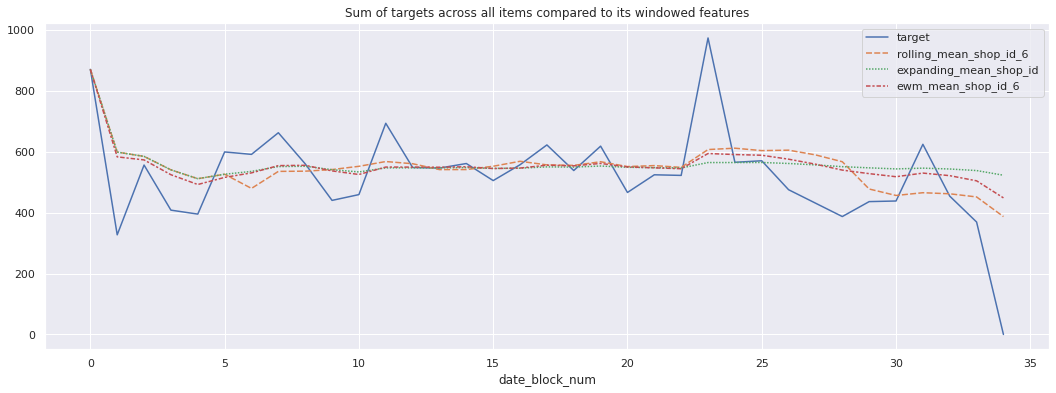

In [78]:
f = plt.subplots(figsize=(18,6))
sns.lineplot(data=windowed_features_df)
plt.title('Sum of targets across all items compared to its windowed features')
plt.show()

In [79]:
del x
del rolling_mean_df
del expanding_mean_df
del ewm_mean_df
del windowed_features_df

### Rolling means for shop groups, item category groups, item groups, shop/item groups

In [80]:
%%time
window_sizes = [3, 6, 12]
all_data = create_windowed_mean_features(all_data, ['shop_id'], 'rolling', window_sizes)[0]
all_data = create_windowed_mean_features(all_data, ['item_category_id'], 'rolling', window_sizes)[0]
all_data = create_windowed_mean_features(all_data, ['shop_id', 'item_id'], 'rolling', window_sizes)[0]
all_data = create_windowed_mean_features(all_data, ['shop_id', 'item_category_id'], 'rolling', window_sizes)[0]
all_data.tail()

CPU times: user 3min 24s, sys: 9.76 s, total: 3min 34s
Wall time: 3min 34s


,date_block_num,shop_id,item_id,item_category_id,target,sum_month_shop,sum_month_item,mean_month_shop,mean_month_item,mean_month_shop_item,...,rolling_mean_shop_id_12,rolling_mean_item_category_id_3,rolling_mean_item_category_id_6,rolling_mean_item_category_id_12,rolling_mean_shop_id_item_id_3,rolling_mean_shop_id_item_id_6,rolling_mean_shop_id_item_id_12,rolling_mean_shop_id_item_category_id_3,rolling_mean_shop_id_item_category_id_6,rolling_mean_shop_id_item_category_id_12
7150005,34,45,18454,55,0.0,0.0,0.0,0.0,0.0,0.0,...,569.833333,5419.333333,5605.000000,6759.833333,0.333333,0.166667,0.818182,67.666667,73.666667,88.166667
7150006,34,45,16188,64,0.0,0.0,0.0,0.0,0.0,0.0,...,569.833333,533.666667,521.500000,693.750000,NaN,NaN,NaN,11.000000,9.166667,10.750000
7150007,34,45,15757,55,0.0,0.0,0.0,0.0,0.0,0.0,...,569.833333,5419.333333,5605.000000,6759.833333,0.000000,0.000000,0.166667,67.666667,73.666667,88.166667
7150008,34,45,19648,40,0.0,0.0,0.0,0.0,0.0,0.0,...,569.833333,7433.333333,8018.666667,9888.166667,0.000000,0.000000,0.000000,72.333333,71.833333,90.500000
7150009,34,45,969,37,0.0,0.0,0.0,0.0,0.0,0.0,...,569.833333,3312.000000,3168.166667,3821.333333,0.000000,0.000000,0.000000,39.000000,46.333333,60.500000


### Expanding means for shop groups, item category groups, item groups, shop/item groups

In [81]:
%%time
all_data = create_windowed_mean_features(all_data, ['shop_id'], 'expanding')[0]
all_data = create_windowed_mean_features(all_data, ['item_category_id'], 'expanding')[0]
all_data = create_windowed_mean_features(all_data, ['shop_id', 'item_id'], 'expanding')[0]
all_data = create_windowed_mean_features(all_data, ['shop_id', 'item_category_id'], 'expanding')[0]
all_data.tail()

CPU times: user 47.4 s, sys: 8.35 s, total: 55.8 s
Wall time: 55.8 s


,date_block_num,shop_id,item_id,item_category_id,target,sum_month_shop,sum_month_item,mean_month_shop,mean_month_item,mean_month_shop_item,...,rolling_mean_shop_id_item_id_3,rolling_mean_shop_id_item_id_6,rolling_mean_shop_id_item_id_12,rolling_mean_shop_id_item_category_id_3,rolling_mean_shop_id_item_category_id_6,rolling_mean_shop_id_item_category_id_12,expanding_mean_shop_id,expanding_mean_item_category_id,expanding_mean_shop_id_item_id,expanding_mean_shop_id_item_category_id
7150005,34,45,18454,55,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.166667,0.818182,67.666667,73.666667,88.166667,936.794118,8321.823529,0.818182,136.735294
7150006,34,45,16188,64,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,11.000000,9.166667,10.750000,936.794118,588.264706,NaN,10.764706
7150007,34,45,15757,55,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.166667,67.666667,73.666667,88.166667,936.794118,8321.823529,0.205882,136.735294
7150008,34,45,19648,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,72.333333,71.833333,90.500000,936.794118,14884.264706,0.000000,192.029412
7150009,34,45,969,37,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,39.000000,46.333333,60.500000,936.794118,4752.647059,0.294118,72.500000


### Exponentially weighted mean (EWM) for shop groups, item category groups

In [82]:
%%time
window_sizes = [1, 2, 3]
all_data = create_windowed_mean_features(all_data, ['shop_id'], 'ewm', window_sizes)[0]
all_data = create_windowed_mean_features(all_data, ['item_category_id'], 'ewm', window_sizes)[0]
all_data = create_windowed_mean_features(all_data, ['shop_id', 'item_id'], 'ewm', window_sizes)[0]
all_data = create_windowed_mean_features(all_data, ['shop_id', 'item_category_id'], 'ewm', window_sizes)[0]
all_data.tail()

CPU times: user 24min 26s, sys: 2min 28s, total: 26min 54s
Wall time: 25min 48s


,date_block_num,shop_id,item_id,item_category_id,target,sum_month_shop,sum_month_item,mean_month_shop,mean_month_item,mean_month_shop_item,...,ewm_mean_shop_id_3,ewm_mean_item_category_id_1,ewm_mean_item_category_id_2,ewm_mean_item_category_id_3,ewm_mean_shop_id_item_id_1,ewm_mean_shop_id_item_id_2,ewm_mean_shop_id_item_id_3,ewm_mean_shop_id_item_category_id_1,ewm_mean_shop_id_item_category_id_2,ewm_mean_shop_id_item_category_id_3
7150005,34,45,18454,55,0.0,0.0,0.0,0.0,0.0,0.0,...,519.603614,5521.518126,5772.332081,6091.881276,0.510015,0.408617,0.448485,73.481754,75.366471,80.424185
7150006,34,45,16188,64,0.0,0.0,0.0,0.0,0.0,0.0,...,519.603614,510.650564,542.265132,571.404466,NaN,NaN,NaN,9.529190,9.702576,9.752529
7150007,34,45,15757,55,0.0,0.0,0.0,0.0,0.0,0.0,...,519.603614,5521.518126,5772.332081,6091.881276,0.002936,0.032837,0.067720,73.481754,75.366471,80.424185
7150008,34,45,19648,40,0.0,0.0,0.0,0.0,0.0,0.0,...,519.603614,7560.416744,8145.386990,8775.282306,0.000000,0.000000,0.000000,68.782959,75.047186,82.570500
7150009,34,45,969,37,0.0,0.0,0.0,0.0,0.0,0.0,...,519.603614,3423.072067,3417.809414,3546.716003,0.000069,0.007359,0.030521,41.663402,47.149093,51.823830


### Checkpoint

Kaggle does not have enough memory to handle this dataset with all its generated features in one go. Hence, we will force the kernel to reset namespace before continuing.

In [83]:
all_data = downcast_dtypes(all_data)
print('Windowed features generated')
gc.collect()

all_data.to_pickle('checkpoint.pkl')
print('Checkpoint saved')

Old dataframe memory usage:	 2147.9 MB
New dataframe memory usage:	 1384.2 MB
Windowed features generated
Checkpoint saved


In [84]:
%reset -f

## Lag features

In [85]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

all_data = pd.read_pickle('checkpoint.pkl')

In [86]:
# function to generate lag features
def lag_generator(df, lag_periods, cols_to_lag):
    
    index_cols = ['shop_id', 'item_id', 'date_block_num']
    
    # generate lags for target and aggregate features
    laggable_cols = cols_to_lag + ['target']
    print(laggable_cols)
    
    for lag_period in tqdm(lag_periods):

        lagged_data = df[index_cols + laggable_cols].copy()  # makes sure only original aggregate columns are lagged
        lagged_data['date_block_num'] = lagged_data['date_block_num'] + lag_period

        new_col_name = lambda x: '{}_lag_{}'.format(x, lag_period) if x in laggable_cols else x
        lagged_data = lagged_data.rename(columns=new_col_name)

        df = pd.merge(df, lagged_data, on=index_cols, how='left').fillna(0)
    return df

In [87]:
lag_periods = [1, 2, 3]
sum_cols = all_data.filter(regex='^sum', axis=1).columns.values.tolist()
mean_cols = all_data.filter(regex='^mean', axis=1).columns.values.tolist()
cols_to_lag = sum_cols + mean_cols

all_data = lag_generator(all_data, lag_periods, cols_to_lag)
print(all_data.shape)
all_data.tail()

['sum_month_shop', 'sum_month_item', 'mean_month_shop', 'mean_month_item', 'mean_month_shop_item', 'mean_month_shop_cat', 'mean_price_month_cat', 'mean_price_month_item', 'mean_month_main', 'mean_month_sub', 'mean_month_cat_newitem', 'mean_month_cat_shop_newitem', 'mean_month_loc', 'mean_month_loc_item', 'mean_month_loc_cat', 'target']


  0%|          | 0/3 [00:00<?, ?it/s]

(7150010, 109)


,date_block_num,shop_id,item_id,item_category_id,target,sum_month_shop,sum_month_item,mean_month_shop,mean_month_item,mean_month_shop_item,...,mean_price_month_cat_lag_3,mean_price_month_item_lag_3,mean_month_main_lag_3,mean_month_sub_lag_3,mean_month_cat_newitem_lag_3,mean_month_cat_shop_newitem_lag_3,mean_month_loc_lag_3,mean_month_loc_item_lag_3,mean_month_loc_cat_lag_3,target_lag_3
7150005,34,45,18454,55,0.0,0.0,0.0,0.0,0.0,0.0,...,311.985657,99.0,0.199497,0.225548,0.451923,0.125000,0.146708,0.0,0.119301,0.0
7150006,34,45,16188,64,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
7150007,34,45,15757,55,0.0,0.0,0.0,0.0,0.0,0.0,...,311.985657,229.0,0.199497,0.225548,0.451923,0.125000,0.146708,0.0,0.119301,0.0
7150008,34,45,19648,40,0.0,0.0,0.0,0.0,0.0,0.0,...,277.063812,99.0,0.227834,0.253893,0.692758,0.263158,0.146708,0.0,0.146061,0.0
7150009,34,45,969,37,0.0,0.0,0.0,0.0,0.0,0.0,...,423.237549,198.0,0.227834,0.194010,3.107692,1.400000,0.146708,0.0,0.109296,0.0


In [88]:
cols_to_lag

['sum_month_shop',
 'sum_month_item',
 'mean_month_shop',
 'mean_month_item',
 'mean_month_shop_item',
 'mean_month_shop_cat',
 'mean_price_month_cat',
 'mean_price_month_item',
 'mean_month_main',
 'mean_month_sub',
 'mean_month_cat_newitem',
 'mean_month_cat_shop_newitem',
 'mean_month_loc',
 'mean_month_loc_item',
 'mean_month_loc_cat']

### Removing original aggregate feature columns without lag
Aggregate feature columns have a value of zero on test set rows as these rows have no target value. These can be removed as the lag features represent the relationship between the test month and previous months. The model should be making predictions based on the values of lag features instead of the constant zero values of original aggregate values in the test set.

In [89]:
all_data.drop(cols_to_lag, axis=1, inplace=True)
all_data.tail()

,date_block_num,shop_id,item_id,item_category_id,target,main_cat_id,sub_cat_id,hols_in_month,month_of_year,year,...,mean_price_month_cat_lag_3,mean_price_month_item_lag_3,mean_month_main_lag_3,mean_month_sub_lag_3,mean_month_cat_newitem_lag_3,mean_month_cat_shop_newitem_lag_3,mean_month_loc_lag_3,mean_month_loc_item_lag_3,mean_month_loc_cat_lag_3,target_lag_3
7150005,34,45,18454,55,0.0,13,36,1,11,2,...,311.985657,99.0,0.199497,0.225548,0.451923,0.125000,0.146708,0.0,0.119301,0.0
7150006,34,45,16188,64,0.0,14,45,1,11,2,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
7150007,34,45,15757,55,0.0,13,36,1,11,2,...,311.985657,229.0,0.199497,0.225548,0.451923,0.125000,0.146708,0.0,0.119301,0.0
7150008,34,45,19648,40,0.0,11,22,1,11,2,...,277.063812,99.0,0.227834,0.253893,0.692758,0.263158,0.146708,0.0,0.146061,0.0
7150009,34,45,969,37,0.0,11,21,1,11,2,...,423.237549,198.0,0.227834,0.194010,3.107692,1.400000,0.146708,0.0,0.109296,0.0


## Final adjustments and output
1. Exclude first few months, since they may have zero values for lag features or abnormal values for windowed features
2. Output file for next notebook for modelling

In [90]:
# ensure first few months are excluded due to zero values in some generated features
# all_data = all_data.loc[all_data['date_block_num'] > 2]

# clip target variable
all_data['target'] = all_data['target'].clip(0,20)

# save checkpoint. no need to downcast data as lag features are already in float32
all_data.to_pickle('checkpoint.pkl')
print('Checkpoint saved')

Checkpoint saved


# Modelling

We will use a LightGBM model due to its simplicity and speed, while still producing good results.

Hyperparameters used in this notebook were tuned in a separate notebook using Optuna's automatic tuner.

## Preparing train, validation and test datasets

In [91]:
%reset -f

In [92]:
import pandas as pd
import gc

# re-read final train data and sample submission format
all_data = pd.read_pickle('checkpoint.pkl')
sample_submission = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')

# save date_block_num as a separate series
months = all_data['date_block_num']

# prepare train, validation, test
cols_to_drop = ['date_block_num', 'target']

X_train = all_data.loc[months < 33, :].drop(cols_to_drop, axis=1)
y_train = all_data.loc[months < 33, 'target']
X_val = all_data.loc[months == 33, :].drop(cols_to_drop, axis=1)
y_val = all_data.loc[months == 33, 'target']
X_test = all_data.loc[months == 34, :].drop(cols_to_drop, axis=1)

# we no longer need imported dataset
del all_data
gc.collect()

0

## Training the model

In [93]:
import lightgbm as lgb

# define categorical features for lightgbm to handle
categoricals = ['item_category_id',
                'shop_id',
                'item_id',
                'main_cat_id',
                'sub_cat_id',
                'item_debut_month_indicator',
                'month_of_year',
                'year']

# best set of parameters obtained through automatic tuning with optuna
params = {'objective': 'rmse', 
          'metric': 'rmse', 
          'verbosity': -1, 
          'boosting_type': 'gbdt', 
          'n_estimators': 3000, 
          'feature_pre_filter': False, 
          'lambda_l1': 0.09318930375630852, 
          'lambda_l2': 0.001242902221168065, 
          'num_leaves': 207, 
          'feature_fraction': 0.5, 
          'bagging_fraction': 1.0, 
          'bagging_freq': 0, 
          'min_child_samples': 20}

# prepare train, validation in lightgbm.Dataset form
dtrain = lgb.Dataset(X_train, y_train)
dval = lgb.Dataset(X_val, y_val)

# train model
evals_result = {}
model = lgb.train(
        params,
        dtrain,
        valid_sets = [dtrain, dval],
        categorical_feature = categoricals,
        verbose_eval = 200, 
        early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	training's rmse: 0.682725	valid_1's rmse: 0.731676


## Feature importances of top 50 features

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

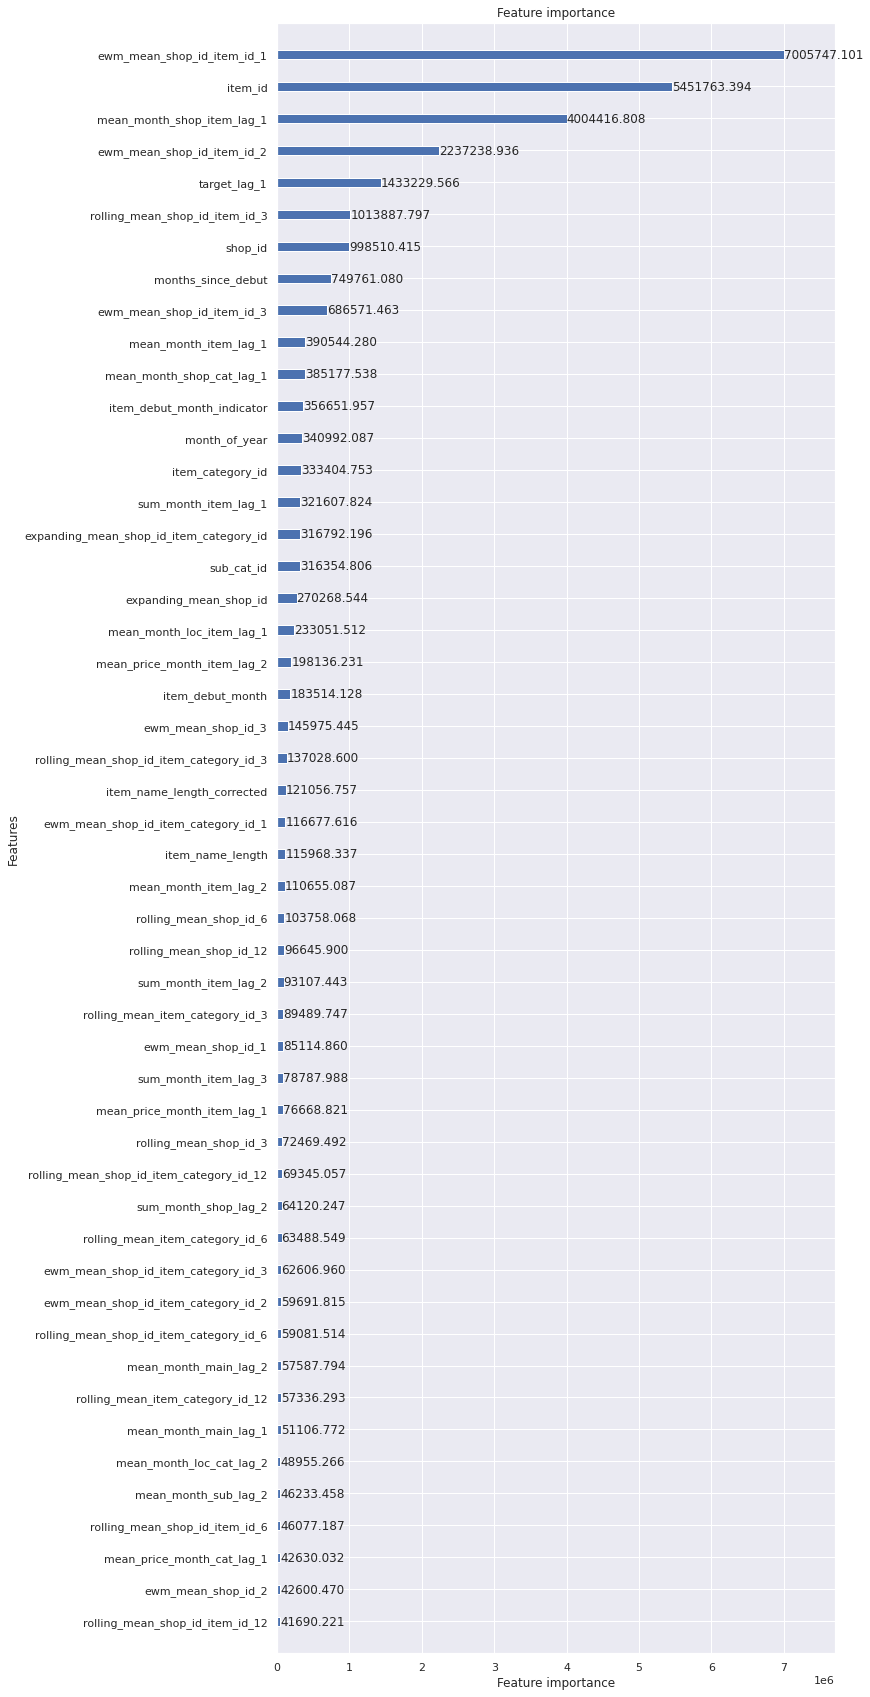

In [94]:
# show relative importance of 50 top features
lgb.plot_importance(model, figsize=(10,30), height=0.3, importance_type="gain", max_num_features=50)

## Prediction and submission

In [101]:
# function to predict on test set and generate submission file
def pred_submit(model, test_df):
    
    # predict on public test data, clip predictions as required by rules
    test_pred = model.predict(test_df)
    np.clip(test_pred, 0, 20, out=test_pred)

    # submission csv file
    submission = sample_submission.copy()
    submission['item_cnt_month'] = test_pred
    print(submission.shape)
    submission.to_csv('submission.csv', index=False)
    
    return submission

In [102]:
import numpy as np
submission = pred_submit(model, X_test)
submission.head()

(214200, 2)


,ID,item_cnt_month
0,0,0.738109
1,1,0.298287
2,2,1.386127
3,3,0.315374
4,4,0.583885
